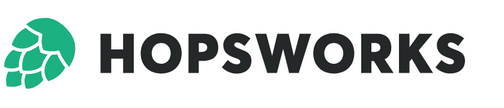


# Part 03: Model training & UI Exploration
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/fraud_batch/3_model_training.ipynb)

In this notebook we will train a model on the dataset we created in the previous tutorial. We will train our model using standard Python and Scikit-learn, although it could just as well be trained with other machine learning frameworks such as PySpark, TensorFlow, and PyTorch. We will also show some of the exploration that can be done in Hopsworks, notably the search functions and the lineage.

## 🗒️ This notebook is divided in 3 main sections:
1. **Loading the training data**
2. **Train the model**
3. **Explore feature groups and views** via the UI.

![tutorial-flow](../images/03_model.png)

In [1]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/167
Connected. Call `.close()` to terminate connection gracefully.


---
## <span style="color:#ff5f27;"> ✨ Load Training Data </span>

First, we'll need to fetch the training dataset that we created in the previous notebook. We will use January - February data training and testing.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

# Load data.
feature_view = fs.get_feature_view(
    name = 'churn_feature_view',
    version = 1
)

X_train, y_train, X_val, y_val, X_test, y_test = feature_view.get_train_validation_test_split(
    training_dataset_version = 1
)

In [3]:
X_train.head()

,contract,tenure,paymentmethod,paperlessbilling,monthlycharges,totalcharges,gender,seniorcitizen,dependents,partner,deviceprotection,onlinebackup,onlinesecurity,internetservice,multiplelines,phoneservice,techsupport,streamingmovies,streamingtv
0,0,0.013889,0,0,0.012456,0.002266,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0.013889,0,0,0.013453,0.002277,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0.013889,0,0,0.014948,0.002295,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0.013889,0,0,0.016442,0.002312,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0.013889,0,0,0.017937,0.002329,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
y_train.head()

,churn
0,0
1,0
2,0
3,1
4,0


---
## <span style="color:#ff5f27;"> 🏃 Train Model</span>

Next we'll train a model. Here, we set the class weight of the positive class to be twice as big as the negative class.

In [5]:
# Train model.
pos_class_weight = 0.9

clf = LogisticRegression(class_weight={0: 1.0 - pos_class_weight, 1: pos_class_weight}, solver='liblinear')

clf.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.09999999999999998, 1: 0.9},
                   solver='liblinear')

Let's see how well it performs on our validation data.

In [6]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

preds = clf.predict(X_val)

precision, recall, fscore, _ = precision_recall_fscore_support(y_val, preds, average="binary")

metrics = {
    'precision': precision,
    'recall': recall,
    'fscore': fscore
}

print(classification_report(y_val, preds))


              precision    recall  f1-score   support

           0       0.98      0.47      0.64      1071
           1       0.39      0.97      0.55       364

    accuracy                           0.60      1435
   macro avg       0.68      0.72      0.60      1435
weighted avg       0.83      0.60      0.62      1435



---
## <span style="color:#ff5f27;">👮🏼‍♀️ Model Registry</span>

In [7]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [8]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

{'input_schema': {'columnar_schema': [{'name': 'contract', 'type': 'int64'},
   {'name': 'tenure', 'type': 'float64'},
   {'name': 'paymentmethod', 'type': 'int64'},
   {'name': 'paperlessbilling', 'type': 'int64'},
   {'name': 'monthlycharges', 'type': 'float64'},
   {'name': 'totalcharges', 'type': 'float64'},
   {'name': 'gender', 'type': 'int64'},
   {'name': 'seniorcitizen', 'type': 'int64'},
   {'name': 'dependents', 'type': 'int64'},
   {'name': 'partner', 'type': 'int64'},
   {'name': 'deviceprotection', 'type': 'int64'},
   {'name': 'onlinebackup', 'type': 'int64'},
   {'name': 'onlinesecurity', 'type': 'int64'},
   {'name': 'internetservice', 'type': 'int64'},
   {'name': 'multiplelines', 'type': 'int64'},
   {'name': 'phoneservice', 'type': 'int64'},
   {'name': 'techsupport', 'type': 'int64'},
   {'name': 'streamingmovies', 'type': 'int64'},
   {'name': 'streamingtv', 'type': 'int64'}]},
 'output_schema': {'columnar_schema': [{'name': 'churn', 'type': 'int64'}]}}

In [9]:
import joblib

pkl_file_name = "churnmodel.pkl"

joblib.dump(clf, pkl_file_name)

model = mr.python.create_model(
    name="churnmodel",
    description = f"Churn Model",
    input_example = X_train.sample(),
    model_schema = model_schema
)

model.save(pkl_file_name)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/167/models/churnmodel/1


Model(name: 'churnmodel', version: 1)

---
## <span style="color:#ff5f27;">🚀 Model Deployment</span>

In [10]:
%%writefile predict_example.py
import os
import hsfs
import joblib
import numpy as np
import pandas as pd

class Predict(object):

    def __init__(self):
        """ Initializes the serving state, reads a trained model"""        
        # get feature store handle
        fs_conn = hsfs.connection()
        self.fs = fs_conn.get_feature_store()
        
        # load the trained model
        self.model = joblib.load(os.environ["ARTIFACT_FILES_PATH"] + "/churnmodel.pkl")
        print("Initialization Complete")

    def predict(self, inputs):
        """ Serves a prediction request usign a trained model"""
        return self.model.predict(np.array(inputs).reshape(1, -1)).tolist()

Overwriting predict_example.py


In [11]:
import os
dataset_api = project.get_dataset_api()

uploaded_file_path = dataset_api.upload("predict_example.py", "Models", overwrite=True)
predictor_script_path = os.path.join("/Projects", project.name, uploaded_file_path)

Uploading: 0.000%|          | 0/661 elapsed<00:00 remaining<?

In [12]:
# Use the model name from the previous notebook.
model = mr.get_model("churnmodel", version = 1)

# Give it any name you want
deployment = model.deploy(
    name="churnmodel", 
    model_server="PYTHON",
    script_file=predictor_script_path
)

Deployment created, explore it at https://c.app.hopsworks.ai:443/p/167/deployments/123
Before making predictions, start the deployment by using `.start()`


In [13]:
# get Hopsworks Model Serving
ms = project.get_model_serving()

# get deployment object
deployment = ms.get_deployment("churnmodel")

Connected. Call `.close()` to terminate connection gracefully.


In [14]:
deployment.start()

  0%|          | 0/1 [00:00<?, ?it/s]

Start making predictions by using `.predict()`


In [15]:
deployment.get_logs()

Explore all the logs and filters in the Kibana logs at https://c.app.hopsworks.ai:443/p/167/deployments/123

Instance name: churnmodel-predictor-default-00001-deployment-d95658454-bw64m
[I 220713 20:51:04 kserve-component-server:27] Initializing predictor for deployment: churnmodel
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
[I 220713 20:51:05 kfserver:150] Registering model: churnmodel
[I 220713 20:51:05 kfserver:120] Setting asyncio max_workers as 5
[I 220713 20:51:05 kfserver:127] Listening on port 8080
[I 220713 20:51:05 kfserver:129] Will fork 1 workers




---
## <span style='color:#ff5f27'>🔮 Predicting</span>

### <span style='color:#ff5f27'>⛳️ Predicting input example</span>

In [16]:
model.input_example

[2.0,
 0.7638888888888888,
 3.0,
 0.0,
 0.0189337319382162,
 0.1244227409786161,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [17]:
data = {
    "inputs": model.input_example
}

deployment.predict(data)

{'predictions': [0]}

### <span style='color:#ff5f27'>⛳️ Predicting batch data</span>

In [18]:
batch_data = feature_view.get_batch_data()

batch_data.head()

2022-07-13 23:51:17,945 INFO: USE `maksym00_featurestore`
2022-07-13 23:51:18,919 INFO: SELECT `fg2`.`contract` `contract`, `fg2`.`tenure` `tenure`, `fg2`.`paymentmethod` `paymentmethod`, `fg2`.`paperlessbilling` `paperlessbilling`, `fg2`.`monthlycharges` `monthlycharges`, `fg2`.`totalcharges` `totalcharges`, `fg0`.`gender` `gender`, `fg0`.`seniorcitizen` `seniorcitizen`, `fg0`.`dependents` `dependents`, `fg0`.`partner` `partner`, `fg1`.`deviceprotection` `deviceprotection`, `fg1`.`onlinebackup` `onlinebackup`, `fg1`.`onlinesecurity` `onlinesecurity`, `fg1`.`internetservice` `internetservice`, `fg1`.`multiplelines` `multiplelines`, `fg1`.`phoneservice` `phoneservice`, `fg1`.`techsupport` `techsupport`, `fg1`.`streamingmovies` `streamingmovies`, `fg1`.`streamingtv` `streamingtv`
FROM `maksym00_featurestore`.`customer_info_1` `fg2`
INNER JOIN `maksym00_featurestore`.`customer_demography_info_1` `fg0` ON `fg2`.`customerid` = `fg0`.`customerid`
INNER JOIN `maksym00_featurestore`.`customer_

,contract,tenure,paymentmethod,paperlessbilling,monthlycharges,totalcharges,gender,seniorcitizen,dependents,partner,deviceprotection,onlinebackup,onlinesecurity,internetservice,multiplelines,phoneservice,techsupport,streamingmovies,streamingtv
0,0,0.444444,0,0,0.428500,0.215008,1,0,1,1,1,2,2,1,0,0,2,1,1
1,0,0.333333,1,1,0.568012,0.201541,1,0,0,1,1,1,1,2,2,0,1,1,1
2,2,0.694444,1,1,0.519183,0.402037,0,0,1,1,1,1,2,1,2,0,2,1,2
3,2,0.638889,0,0,0.018435,0.102664,1,0,1,1,0,0,0,0,0,0,0,0,0
4,1,0.777778,2,1,0.793224,0.607741,1,0,0,1,1,1,2,2,2,0,1,2,2


In [19]:
def get_predictions(row, deployment = deployment):
    data = {
        'inputs': row.tolist()
    }
    return deployment.predict(data)

In [20]:
batch_data.iloc[:10].apply(get_predictions,axis = 1)

0    {'predictions': [0]}
1    {'predictions': [1]}
2    {'predictions': [0]}
3    {'predictions': [0]}
4    {'predictions': [1]}
5    {'predictions': [1]}
6    {'predictions': [1]}
7    {'predictions': [1]}
8    {'predictions': [1]}
9    {'predictions': [1]}
dtype: object

---
## <span style="color:#ff5f27;">👨🏻‍🎨 Data Visualisation </span>

In [21]:
df_all = feature_view.query.read()

df_all.head()

2022-07-13 23:51:50,307 INFO: USE `maksym00_featurestore`
2022-07-13 23:51:51,323 INFO: SELECT `fg2`.`contract` `contract`, `fg2`.`tenure` `tenure`, `fg2`.`paymentmethod` `paymentmethod`, `fg2`.`paperlessbilling` `paperlessbilling`, `fg2`.`monthlycharges` `monthlycharges`, `fg2`.`totalcharges` `totalcharges`, `fg2`.`churn` `churn`, `fg0`.`gender` `gender`, `fg0`.`seniorcitizen` `seniorcitizen`, `fg0`.`dependents` `dependents`, `fg0`.`partner` `partner`, `fg1`.`deviceprotection` `deviceprotection`, `fg1`.`onlinebackup` `onlinebackup`, `fg1`.`onlinesecurity` `onlinesecurity`, `fg1`.`internetservice` `internetservice`, `fg1`.`multiplelines` `multiplelines`, `fg1`.`phoneservice` `phoneservice`, `fg1`.`techsupport` `techsupport`, `fg1`.`streamingmovies` `streamingmovies`, `fg1`.`streamingtv` `streamingtv`
FROM `maksym00_featurestore`.`customer_info_1` `fg2`
INNER JOIN `maksym00_featurestore`.`customer_demography_info_1` `fg0` ON `fg2`.`customerid` = `fg0`.`customerid`
INNER JOIN `maksym00_f

,contract,tenure,paymentmethod,paperlessbilling,monthlycharges,totalcharges,churn,gender,seniorcitizen,dependents,partner,deviceprotection,onlinebackup,onlinesecurity,internetservice,multiplelines,phoneservice,techsupport,streamingmovies,streamingtv
0,Month-to-month,32,Bank transfer (automatic),No,61.40,1864.65,0,Female,0,Yes,Yes,No,Yes,Yes,DSL,No,Yes,Yes,No,No
1,Month-to-month,24,Credit card (automatic),Yes,75.40,1747.85,1,Female,0,No,Yes,No,No,No,Fiber optic,Yes,Yes,No,No,No
2,Two year,50,Credit card (automatic),Yes,70.50,3486.65,0,Male,0,Yes,Yes,No,No,Yes,DSL,Yes,Yes,Yes,No,Yes
3,Two year,46,Bank transfer (automatic),No,20.25,890.35,0,Female,0,Yes,Yes,No internet service,No internet service,No internet service,No,No,Yes,No internet service,No internet service,No internet service
4,One year,56,Electronic check,Yes,98.00,5270.60,0,Female,0,No,Yes,No,No,Yes,Fiber optic,Yes,Yes,No,Yes,Yes


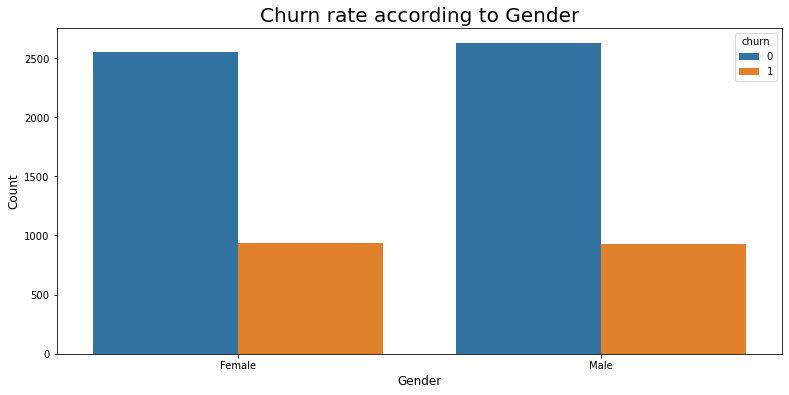

In [22]:
plt.figure(figsize = (13,6))

sns.countplot(
    data = df_all,
    x = 'gender',
    hue = 'churn'
)

plt.title('Churn rate according to Gender', fontsize = 20)
plt.xlabel("Gender", fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.show()

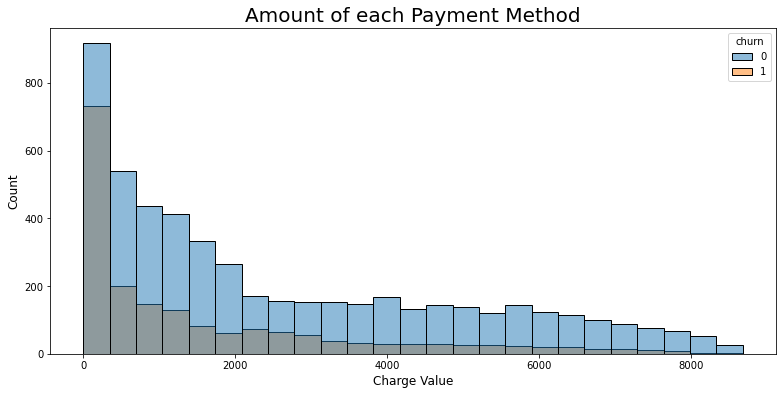

In [23]:
plt.figure(figsize = (13,6))

sns.histplot(
    data = df_all,
    x = 'totalcharges',
    hue = 'churn'
)

plt.title('Amount of each Payment Method', fontsize = 20)
plt.xlabel("Charge Value", fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.show()

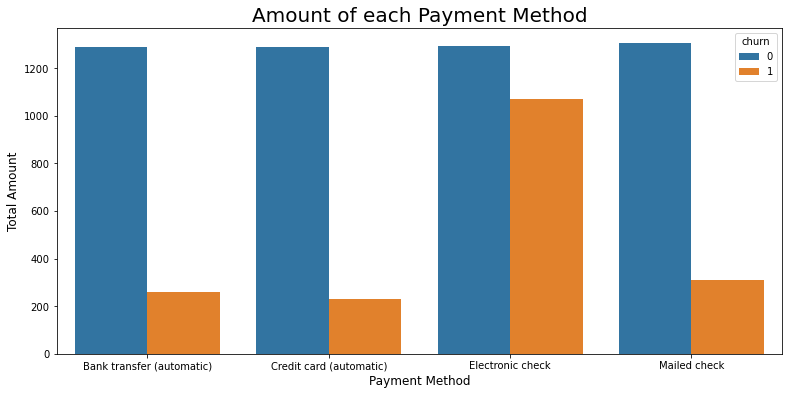

In [24]:
plt.figure(figsize = (13,6))

sns.countplot(
    data = df_all,
    x = 'paymentmethod',
    hue = 'churn'
)

plt.title('Amount of each Payment Method', fontsize = 20)
plt.xlabel("Payment Method", fontsize = 12)
plt.ylabel('Total Amount', fontsize = 12)

plt.show()

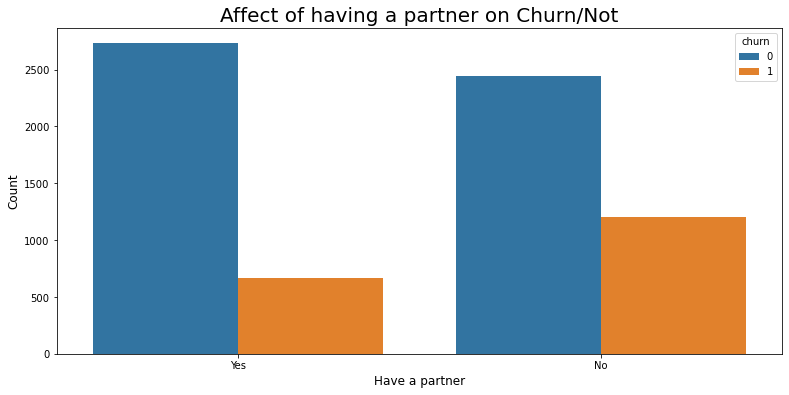

In [25]:
plt.figure(figsize = (13,6))

sns.countplot(
    data = df_all,
    x = 'partner',
    hue = 'churn'
)

plt.title('Affect of having a partner on Churn/Not', fontsize = 20)
plt.xlabel("Have a partner", fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.show()

---
## <span style="color:#ff5f27;">🧑🏻‍🔬 StreamLit App </span>

If you want to see **interactive dashboards** - use a StreamLit App.

Type the next commands in terminal to run a Streamlit App:

`cd {churn_project_path}`

`streamlit run streamlit_app.py`

---
## <span style="color:#ff5f27;"> 👓  Exploration</span>
In the Hopsworks feature store, the metadata allows for multiple levels of explorations and review. Here we will show a few of those capacities. 

### <span style="color:#ff5f27;">🔎 <b>Search</b></span> 
Using the search function in the ui, you can query any aspect of the feature groups, feature_view and training data that was previously created.

### <span style="color:#ff5f27;">📊 <b>Statistics</b> </span>
We can also enable statistics in one or all the feature groups.

In [26]:
customer_info_fg = fs.get_feature_group("customer_info", version = 1)
customer_info_fg.statistics_config = {
    "enabled": True,
    "histograms": True,
    "correlations": True
}

customer_info_fg.update_statistics_config()
customer_info_fg.compute_statistics()

Statistics Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/167/jobs/named/customer_info_1_compute_stats_13072022205222/executions


![fg-statistics](../images/fg_statistics.gif)


### <span style="color:#ff5f27;">⛓️ <b> Lineage </b> </span>
In all the feature groups and feature view you can look at the relation between each abstractions; what feature group created which training dataset and that is used in which model.
This allows for a clear undestanding of the pipeline in relation to each element. 

---
## <span style="color:#ff5f27;"> 🎁  Wrapping things up </span>

We have now performed a simple training with training data that we have created in the feature store. This concludes the fisrt module and introduction to the core aspect of the feauture store. 